In [1]:
using Distributions
using StatsBase
using PyPlot
using Mamba

# アヒル本4章のデータ
x=Real[ 24, 24, 26, 32, 33, 35, 38, 40, 40, 43, 43, 44, 48, 52,  56,  56,  57,  58,  59,  59]
y=Real[472,403,454,575,546,781,750,601,814,792,745,837,868,988,1092,1007,1233,1202,1123,1314]

20-element Array{Real,1}:
  472
  403
  454
  575
  546
  781
  750
  601
  814
  792
  745
  837
  868
  988
 1092
 1007
 1233
 1202
 1123
 1314

In [50]:
# Raw level mamba.jl implementation
logfgrad = function(X::DenseVector)
  _a = X[1]
  _b = X[2]
  _sigma = X[3]
  y_pred = _a + _b * x
  logf = sum(logpdf(Normal(aa, _sigma), bb) for (aa,bb) in zip(y_pred,y))
  grad = [
    sum(y - y_pred)/_sigma^2,
    dot(x, y - y_pred)/_sigma^2,
    -1.0/_sigma*length(x) + sum(abs2,y - y_pred)/_sigma^3   
  ]            
  logf, grad
end

## MCMC Simulation with Hamiltonian Monte Carlo
n = 10000
sim1 = Chains(n, 3, names = ["a", "b", "sigma"])
epsilon = 0.2
L = 100
Sigma = eye(3)
theta = HMCVariate([-80.0,21.0, 80.0], epsilon, L, logfgrad)
for i in 1:n
  sample!(theta)
  sim1[i, :, 1] = [theta[1:3];]
end
describe(sim1)

Iterations = 1:10000
Thinning interval = 1
Chains = 1
Samples per chain = 10000

Empirical Posterior Estimates:
          Mean        SD       Naive SE      MCSE        ESS   
    a -119.918028 72.8994392 0.728994392 4.929565200  218.69112
    b   21.906528  1.6280541 0.016280541 0.106257745  234.75588
sigma   84.959823 15.1834910 0.151834910 0.289354403 2753.48735

Quantiles:
          2.5%       25.0%       50.0%      75.0%      97.5%  
    a -260.121554 -168.383881 -120.913631 -74.13186  26.061056
    b   18.617547   20.896101   21.919803  22.96806  25.095578
sigma   61.117440   73.966300   82.769381  93.79077 120.328988



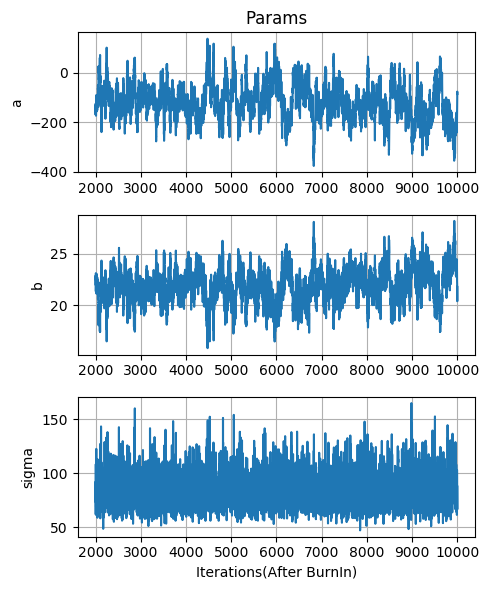

In [51]:
# Plot 
iterations=2001:10000

fig = figure(figsize=(5,6))
ax = fig[:add_subplot](3,1,1)
PyPlot.plot(iterations,sim1.value[2001:end,1])
ylabel("a")
title("Params")
grid("on")

ax = fig[:add_subplot](3,1,2)
PyPlot.plot(iterations,sim1.value[2001:end,2])
ylabel("b")
grid("on")

ax = fig[:add_subplot](3,1,3)
PyPlot.plot(iterations,sim1.value[2001:end,3])
xlabel("Iterations(After BurnIn)")
ylabel("sigma")
grid("on")

tight_layout()

In [2]:
# Model Definition
model = Model(
    y = Stochastic(1,
        (a, b, x, sigma) -> MvNormal(a + b*x, sigma),
        false
    ),
    b = Stochastic(() -> Normal(0, 1000)),
    a = Stochastic(() -> Normal(0, 1000)),
    sigma = Stochastic(() -> Uniform(0, 1e6))
)

Object of type "Mamba.Model"
-------------------------------------------------------------------------------
a:
A monitored node of type "Mamba.ScalarStochastic"
NaN
-------------------------------------------------------------------------------
b:
A monitored node of type "Mamba.ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element Mamba.ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
sigma:
A monitored node of type "Mamba.ScalarStochastic"
NaN


In [3]:
# Data Conversion
Dat = Dict{Symbol, Any}(
    :x => x,
    :y => y
)

# Initial Values
inits = [
  Dict{Symbol, Any}(
    :y => y,
    :a => rand(Normal(-120, 1)),
    :b => rand(Normal(20, 1)),
    :sigma => rand(Uniform(80,85))
  ) for i in 1:2
]

2-element Array{Dict{Symbol,Any},1}:
 Dict{Symbol,Any}(Pair{Symbol,Any}(:a, -119.303),Pair{Symbol,Any}(:b, 19.0642),Pair{Symbol,Any}(:y, Real[472, 403, 454, 575, 546, 781, 750, 601, 814, 792, 745, 837, 868, 988, 1092, 1007, 1233, 1202, 1123, 1314]),Pair{Symbol,Any}(:sigma, 83.8431))
 Dict{Symbol,Any}(Pair{Symbol,Any}(:a, -118.837),Pair{Symbol,Any}(:b, 20.984),Pair{Symbol,Any}(:y, Real[472, 403, 454, 575, 546, 781, 750, 601, 814, 792, 745, 837, 868, 988, 1092, 1007, 1233, 1202, 1123, 1314]),Pair{Symbol,Any}(:sigma, 84.4297)) 

In [4]:
## Sampling Scheme
# scheme = [HMC([:a,:b],0.01,10),HMC(:sigma,0.01,10)]
scheme = [HMC([:a,:b,:sigma],0.2,100)]
setsamplers!(model, scheme)

Object of type "Mamba.Model"
-------------------------------------------------------------------------------
a:
A monitored node of type "Mamba.ScalarStochastic"
NaN
-------------------------------------------------------------------------------
b:
A monitored node of type "Mamba.ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element Mamba.ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
sigma:
A monitored node of type "Mamba.ScalarStochastic"
NaN


In [5]:
## MCMC Simulations
sim = mcmc(model, Dat, inits, 50000, burnin=2000, thin=1, chains=1)
describe(sim)

MCMC Simulation of 50000 Iterations x 1 Chain...

Chain 1:   0% [2:56:23 of 2:56:25 remaining]
Chain 1:  10% [0:18:05 of 0:20:06 remaining]
Chain 1:  20% [0:16:06 of 0:20:07 remaining]
Chain 1:  30% [0:13:59 of 0:19:59 remaining]
Chain 1:  40% [0:11:57 of 0:19:55 remaining]
Chain 1:  50% [0:09:57 of 0:19:54 remaining]
Chain 1:  60% [0:07:57 of 0:19:52 remaining]
Chain 1:  70% [0:05:57 of 0:19:50 remaining]
Chain 1:  80% [0:03:58 of 0:19:49 remaining]
Chain 1:  90% [0:01:59 of 0:19:50 remaining]
Chain 1: 100% [0:00:00 of 0:19:49 remaining]

Iterations = 2001:50000
Thinning interval = 1
Chains = 1
Samples per chain = 48000

Empirical Posterior Estimates:
          Mean        SD       Naive SE       MCSE       ESS   
sigma   85.210380 15.3700643 0.0701544244 0.221187393 4828.7045
    b   21.838044  1.6152715 0.0073726717 0.049238508 1076.1709
    a -116.704172 72.8083621 0.3323231856 2.301528704 1000.7595

Quantiles:
          2.5%       25.0%       50.0%      75.0%      97.5%  
sigma   

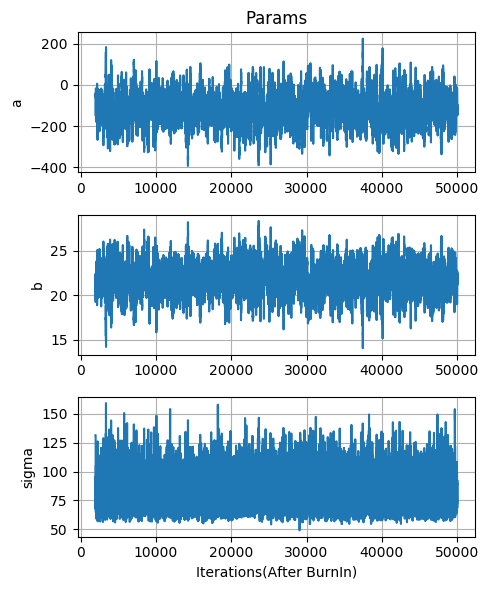

In [9]:
# Plot 
iterations=2001:50000

fig = figure(figsize=(5,6))
ax = fig[:add_subplot](3,1,1)
PyPlot.plot(iterations,sim.value[:,3,1])
ylabel("a")
title("Params")
grid("on")

ax = fig[:add_subplot](3,1,2)
PyPlot.plot(iterations,sim.value[:,2,1])
ylabel("b")
grid("on")

ax = fig[:add_subplot](3,1,3)
PyPlot.plot(iterations,sim.value[:,1,1])
xlabel("Iterations(After BurnIn)")
ylabel("sigma")
grid("on")

tight_layout()

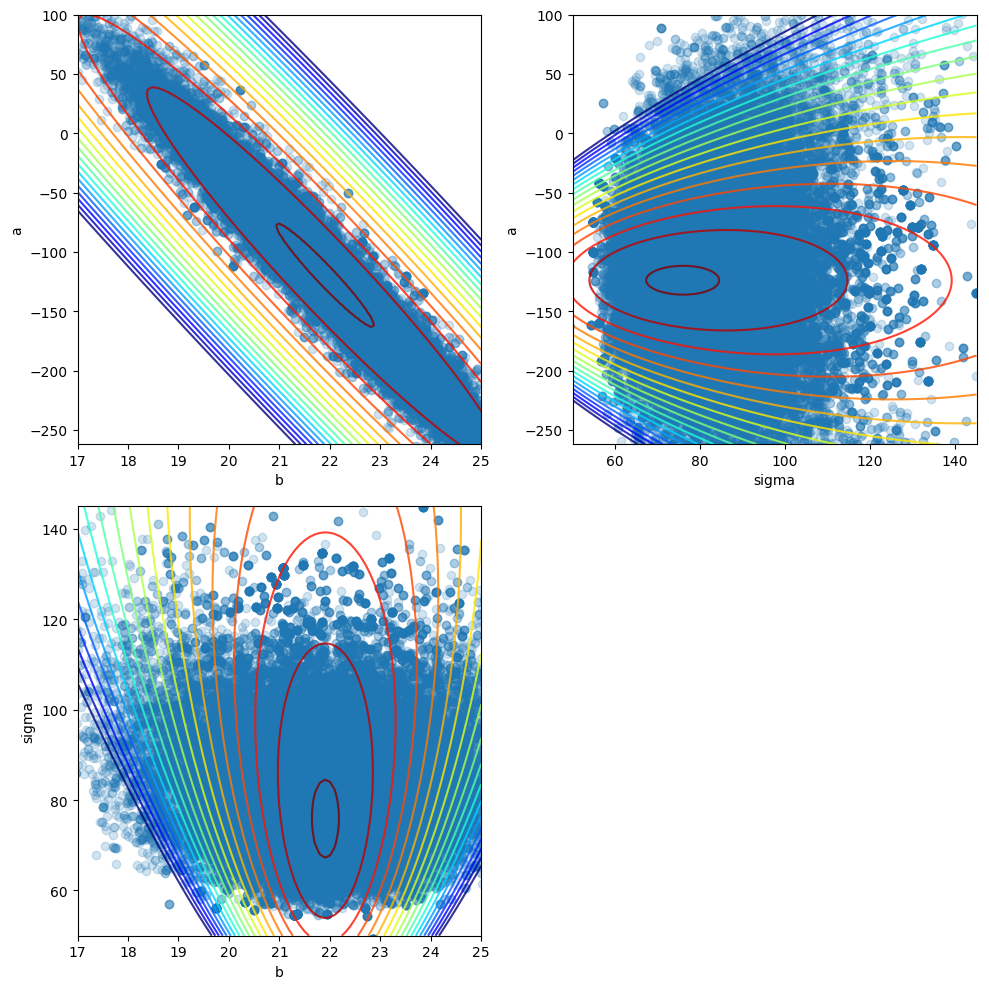

In [7]:
function likelihood(a, b, sigma)
    y_pred = a + b*x
    likelihoods = [logpdf(Normal(aa, sigma), bb) for (aa,bb) in zip(y_pred,y)]
    l_sum = sum(likelihoods)
    return l_sum
end

_a = -120.0
_b = 22.0
_sigma = 79.0

a_list = collect(-262:100)
b_list = collect(17:0.1:25)
sigma_list = collect(50:145)

ab_list = [likelihood(tmp_a,tmp_b,_sigma) for tmp_a in a_list, tmp_b in b_list]
ac_list = [likelihood(tmp_a,_b,    tmp_sigma) for tmp_a in a_list, tmp_sigma in sigma_list]
cb_list = [likelihood(_a, tmp_b,tmp_sigma) for tmp_sigma in sigma_list, tmp_b in b_list]

levels = collect(-160:2.5:-115)

# 結果の取り出し
a = sim.value[:,3,1]
b = sim.value[:,2,1]
sigma = sim.value[:,1,1]

# Plot 
fig = figure(figsize=(10,10))
ax = fig[:add_subplot](2,2,1)

b_grid = repmat(b_list',length(a_list),1)
a_grid = repmat(a_list, 1, length(b_list))

cp = ax[:contour](b_grid,a_grid, ab_list, levels=levels, linewidth=2.0, cmap="jet",alpha=0.8)
scatter(b,a,alpha=0.2)
xlabel("b")
ylabel("a")
ax[:set_xlim]([b_list[1],b_list[end]])
ax[:set_ylim]([a_list[1],a_list[end]])

subplot(222)
ax = fig[:add_subplot](2,2,2)

c_grid = repmat(sigma_list',length(a_list),1)
a_grid = repmat(a_list, 1, length(sigma_list))

cp = ax[:contour](c_grid,a_grid, ac_list, levels=levels, linewidth=2.0, cmap="jet",alpha=0.8)
scatter(sigma,a,alpha=0.2)
xlabel("sigma")
ylabel("a")
ax[:set_xlim]([sigma_list[1],sigma_list[end]])
ax[:set_ylim]([a_list[1],a_list[end]])

subplot(223)
ax = fig[:add_subplot](2,2,3)

b_grid = repmat(b_list',length(sigma_list),1)
c_grid = repmat(sigma_list, 1, length(b_list))

cp = ax[:contour](b_grid,c_grid, cb_list, levels=levels, linewidth=2.0, cmap="jet",alpha=0.8)
scatter(b,sigma,alpha=0.2)
xlabel("b")
ylabel("sigma")
ax[:set_xlim]([b_list[1],b_list[end]])
ax[:set_ylim]([sigma_list[1],sigma_list[end]])
tight_layout()

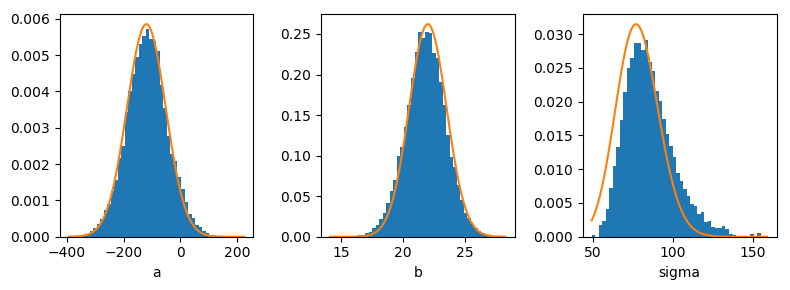

In [8]:
fig = figure("pyplot_histogram",figsize=(8,3))

ax = fig[:add_subplot](1,3,1)
h = plt[:hist](a,50, normed=true)
plottyx = collect(minimum(a):maximum(a))
PyPlot.plot(plottyx, pdf.(Normal(_a,68.15),plottyx))
xlabel("a")

ax = fig[:add_subplot](1,3,2)
h = plt[:hist](b,50, normed=true)
plottyx = collect(minimum(b):0.2:maximum(b))
PyPlot.plot(plottyx, pdf.(Normal(_b,1.52),plottyx))
xlabel("b")

ax = fig[:add_subplot](1,3,3)
h = plt[:hist](sigma,50, normed=true)
plottyx = collect(minimum(sigma):maximum(sigma))
PyPlot.plot(plottyx, pdf.(Chi(18),plottyx/(79.1/sqrt(18)))/18)
xlabel("sigma")

tight_layout()